In [1]:
import json
import math

def normalize_log(value):
    """로그 변환을 통한 간단한 정규화 함수"""
    return math.log(value + 1)

def compute_benefits_score(benefits):
    """
    복리후생 점수 산출:
    - benefits가 존재하면, 제공하는 복리후생 항목 수에 따라 점수를 부여합니다.
    - 예시: 섹션당 1점, 각 항목당 0.5점
    """
    score = 0
    if benefits and isinstance(benefits, dict):
        sections = benefits.get('sections', [])
        score += len(sections)  # 섹션 수
        for section in sections:
            body = section.get('body', [])
            score += 0.5 * len(body)  # 각 항목당 0.5점
    return score

def compute_company_score(company, base_weights=None):
    """
    company: 기업정보 dict
    base_weights: 각 항목의 기본 가중치 dictionary. 예: {'likes':0.5, 'salary':0.3, 'headCount':0.1, 'benefits':0.1}
    """
    # 기본 가중치 설정
    if base_weights is None:
        base_weights = {'likes': 0.5, 'salary': 0.3, 'headCount': 0.1, 'benefits': 0.1}

    # 사용 가능한 지표 확인
    available_metrics = {}
    
    # Likes 처리
    likes = company.get('likes')
    if likes is not None:
        available_metrics['likes'] = normalize_log(likes)
    
    # 연봉 처리 (salary.allAvg)
    salary_info = company.get('salary')
    if salary_info and salary_info.get('allAvg') is not None:
        # 연봉은 그대로 사용하거나 필요에 따라 추가 정규화할 수 있음
        available_metrics['salary'] = salary_info['allAvg']
    
    # 기업 규모 처리 (headCount)
    headcount = company.get('headCount')
    if headcount is not None:
        available_metrics['headCount'] = normalize_log(headcount)
    
    # 복리후생 처리
    benefits = company.get('benefits')
    benefits_score = compute_benefits_score(benefits)
    if benefits_score > 0:
        available_metrics['benefits'] = benefits_score

    # 사용 가능한 지표에 해당하는 가중치 추출 및 재조정 (합이 1이 되도록)
    used_weights = {metric: base_weights[metric] for metric in available_metrics if metric in base_weights}
    total_weight = sum(used_weights.values())
    if total_weight == 0:
        return 0  # 산출할 지표가 없는 경우 0 반환
    # 재조정된 가중치
    adjusted_weights = {metric: weight / total_weight for metric, weight in used_weights.items()}
    
    # 최종 점수 계산
    score = 0
    for metric, value in available_metrics.items():
        score += adjusted_weights[metric] * value
    
    return score

# JSON 파일 경로 지정
json_file_path = "./crawling/현대자동차.json"

# 파일 읽기 및 점수 계산
try:
    with open(json_file_path, "r", encoding="utf-8") as f:
        company_data = json.load(f)
    score = compute_company_score(company_data)
    print(f"기업 점수: {score:.2f}")
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {json_file_path}")
except json.JSONDecodeError as e:
    print(f"JSON 파싱 에러: {e}")


기업 점수: 3529.06


In [ ]:
import json
import math

def normalize_log(value, expected_max):
    """
    로그 변환 후, 기대 최대치(expected_max)로 정규화하여 0~100 사이의 값으로 변환합니다.
    expected_max: 해당 지표의 최대값(예상) 또는 정규화 기준 값
    """
    # 기대 최대치를 로그 변환하여 기준값 산출
    max_log = math.log(expected_max + 1)
    return (math.log(value + 1) / max_log) * 100 if max_log > 0 else 0

def normalize_direct(value, expected_max):
    """
    value를 기대 최대치(expected_max)로 정규화하여 0~100 사이의 값으로 변환합니다.
    """
    return (value / expected_max) * 100 if expected_max > 0 else 0

def compute_benefits_score(benefits, expected_max=10):
    """
    복리후생 점수를 산출한 후 기대 최대치로 정규화합니다.
    - benefits가 존재하면, 제공하는 복리후생 항목 수에 따라 점수를 부여합니다.
    - 예시: 섹션당 1점, 각 항목당 0.5점
    기대 최대치는 실제 제공 가능한 최대치에 따라 조정할 수 있습니다.
    """
    raw_score = 0
    if benefits and isinstance(benefits, dict):
        sections = benefits.get('sections', [])
        raw_score += len(sections)  # 섹션 수
        for section in sections:
            body = section.get('body', [])
            raw_score += 0.5 * len(body)  # 각 항목당 0.5점
    # 기대 최대치로 정규화 (0~100)
    return normalize_direct(raw_score, expected_max)

def compute_company_score(company, base_weights=None, expected_values=None):

    # 기본 가중치 설정
    if base_weights is None:
        base_weights = {'likes': 0.6, 'salary': 0.25, 'headCount': 0.1, 'benefits': 0.05}
    # 기본 기대값 설정
    if expected_values is None:
        expected_values = {
            'likes': 70000,     # 예: 좋아요 최대값 (실제 데이터 분포에 따라 조정)
            'salary': 20000,     # 예: 평균 연봉 최대값 (만원 단위)
            'headCount': 160000, # 예: 기업 규모 최대값
            'benefits': 50       # 예: 복리후생 점수 최대값
        }
    
    normalized_metrics = {}
    
    # Likes 처리 (로그 정규화)
    likes = company.get('likes')
    if likes is not None:
        normalized_metrics['likes'] = normalize_log(likes, expected_values['likes'])
    
    # 연봉 처리 (salary.allAvg) - 직접 정규화 (0~100)
    salary_info = company.get('salary')
    if salary_info and salary_info.get('allAvg') is not None:
        salary = salary_info['allAvg']
        normalized_metrics['salary'] = normalize_direct(salary, expected_values['salary'])
    
    # 기업 규모 처리 (headCount) - 로그 정규화
    headcount = company.get('headCount')
    if headcount is not None:
        normalized_metrics['headCount'] = normalize_log(headcount, expected_values['headCount'])
    
    # 복리후생 처리
    benefits = company.get('benefits')
    benefits_score = compute_benefits_score(benefits, expected_max=expected_values['benefits'])
    # benefits_score가 0보다 크면 포함
    if benefits_score > 0:
        normalized_metrics['benefits'] = benefits_score

    # 사용 가능한 지표에 해당하는 가중치 추출 및 재조정 (합이 1이 되도록)
    used_weights = {metric: base_weights[metric] for metric in normalized_metrics if metric in base_weights}
    total_weight = sum(used_weights.values())
    if total_weight == 0:
        return 0  # 산출할 지표가 없는 경우 0 반환
    # 재조정된 가중치
    adjusted_weights = {metric: weight / total_weight for metric, weight in used_weights.items()}
    
    # 최종 점수 계산 (각 항목은 0~100 사이의 값)
    score = 0
    for metric, value in normalized_metrics.items():
        score += adjusted_weights[metric] * value
    
    return score

# JSON 파일 경로 지정 (하드코딩 대신 파일에서 읽음)
json_file_path = "./crawling/현대자동차.json"

try:
    with open(json_file_path, "r", encoding="utf-8") as f:
        company_data = json.load(f)
    
    score = compute_company_score(company_data)
    print(f"기업 점수: {score:.2f} (0~100)")
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {json_file_path}")
except json.JSONDecodeError as e:
    print(f"JSON 파싱 에러: {e}")


기업 점수: 88.47 (0~100)


In [11]:
import os
import json
import math
import csv

def normalize_log(value, expected_max):
    """로그 변환 후, 기대 최대치(expected_max)로 정규화하여 0~100 사이의 값으로 변환"""
    max_log = math.log(expected_max + 1)
    return (math.log(value + 1) / max_log) * 100 if max_log > 0 else 0

def normalize_direct(value, expected_max):
    """value를 기대 최대치(expected_max)로 정규화하여 0~100 사이의 값으로 변환"""
    return (value / expected_max) * 100 if expected_max > 0 else 0

def compute_benefits_score(benefits, expected_max=10):
    """
    복리후생 점수를 산출 후 기대 최대치로 정규화
    - 섹션당 1점, 각 항목당 0.5점 부여
    """
    raw_score = 0
    if benefits and isinstance(benefits, dict):
        sections = benefits.get('sections', [])
        raw_score += len(sections)
        for section in sections:
            body = section.get('body', [])
            raw_score += 0.5 * len(body)
    return normalize_direct(raw_score, expected_max)

def compute_company_score(company, base_weights=None, expected_values=None):
    # 기본 가중치 설정
    if base_weights is None:
        base_weights = {'likes': 0.6, 'salary': 0.25, 'headCount': 0.1, 'benefits': 0.05}
    # 기본 기대값 설정
    if expected_values is None:
        expected_values = {
            'likes': 70000,     # 예: 좋아요 최대값 (실제 데이터 분포에 따라 조정)
            'salary': 20000,     # 예: 평균 연봉 최대값 (만원 단위)
            'headCount': 160000, # 예: 기업 규모 최대값
            'benefits': 50       # 예: 복리후생 점수 최대값
        }
    
    normalized_metrics = {}
    
    # likes (로그 정규화)
    likes = company.get('likes')
    if likes is not None:
        normalized_metrics['likes'] = normalize_log(likes, expected_values['likes'])
    
    # salary (직접 정규화; salary.allAvg)
    salary_info = company.get('salary')
    if salary_info and salary_info.get('allAvg') is not None:
        salary = salary_info['allAvg']
        normalized_metrics['salary'] = normalize_direct(salary, expected_values['salary'])
    
    # headCount (로그 정규화)
    headcount = company.get('headCount')
    if headcount is not None:
        normalized_metrics['headCount'] = normalize_log(headcount, expected_values['headCount'])
    
    # benefits (복리후생)
    benefits = company.get('benefits')
    benefits_score = compute_benefits_score(benefits, expected_max=expected_values['benefits'])
    if benefits_score > 0:
        normalized_metrics['benefits'] = benefits_score

    # 사용 가능한 지표에 대해 가중치 재조정 (합 1)
    used_weights = {metric: base_weights[metric] for metric in normalized_metrics if metric in base_weights}
    total_weight = sum(used_weights.values())
    if total_weight == 0:
        return 0
    adjusted_weights = {metric: weight / total_weight for metric, weight in used_weights.items()}
    
    # 최종 점수 산출
    score = sum(adjusted_weights[metric] * value for metric, value in normalized_metrics.items())
    return score

def process_all_companies(crawling_dir="./crawling", output_csv="company_scores2.csv"):
    """
    crawling_dir 폴더 내 모든 JSON 파일을 읽어 기업 점수를 계산 후, 결과를 CSV 파일로 저장
    CSV 파일 컬럼: 파일명, 회사명, 점수
    """
    results = []
    
    # crawling 폴더 내 파일 목록을 순회 (json 파일만 처리)
    for file_name in os.listdir(crawling_dir):
        if file_name.endswith(".json"):
            file_path = os.path.join(crawling_dir, file_name)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    company_data = json.load(f)
                company_name = company_data.get("companyName", "알 수 없음")
                score = compute_company_score(company_data)
                results.append({
                    "file": file_name,
                    "companyName": company_name,
                    "score": round(score, 2)
                })
            except Exception as e:
                print(f"파일 처리 중 에러 발생: {file_path}, 에러: {e}")

    # CSV 파일로 저장
    with open(output_csv, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["file", "companyName", "score"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in results:
            writer.writerow(row)
    
    print(f"총 {len(results)}개의 기업 데이터를 처리하여 {output_csv} 파일로 저장하였습니다.")

# 실행 예시
if __name__ == "__main__":
    process_all_companies()


총 4056개의 기업 데이터를 처리하여 company_scores2.csv 파일로 저장하였습니다.


===== 기초 통계 =====
count    4056.00
mean       41.03
std        11.81
min         4.32
25%        33.32
50%        40.57
75%        48.63
max        82.76
Name: score, dtype: float64


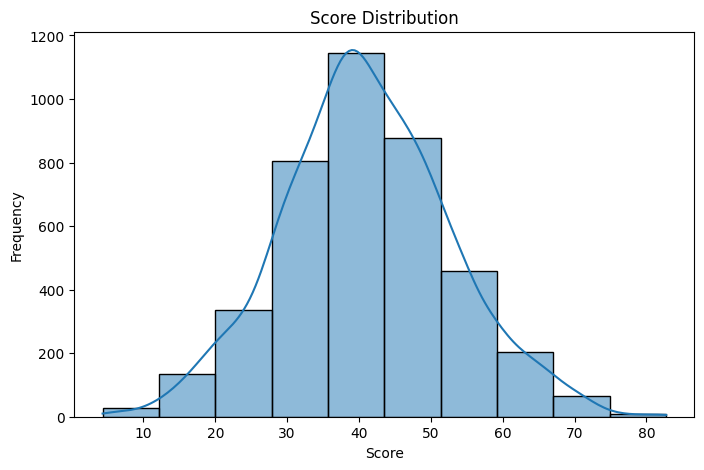

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV 불러오기
df = pd.read_csv("company_scores2.csv", encoding="cp949")

# 1) 기본 통계량
print("===== 기초 통계 =====")
stats = df['score'].describe().round(2)
print(stats)

# 2) 히스토그램
plt.figure(figsize=(8, 5))
sns.histplot(df['score'], bins=10, kde=True)  # bins=10: 구간 수, kde=True: 커널 밀도 곡선
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


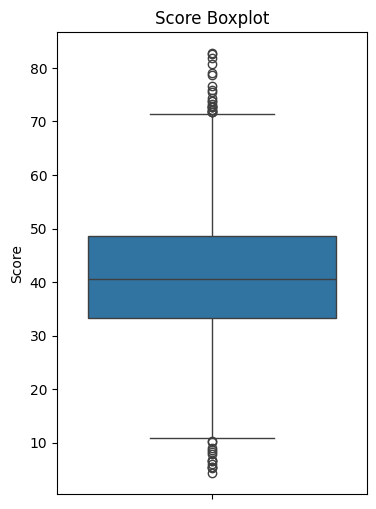

In [15]:
plt.figure(figsize=(4, 6))
sns.boxplot(y=df['score'])
plt.title("Score Boxplot")
plt.ylabel("Score")
plt.show()
